# Detect malicious users in WhatsApp public groups
* Malicious users repeatedly and intentionaly spread misinformation (bots, cyborgs, trolls)
* Low credibility / gullible users
* Superspreaders / influencers/ persuaders
* Source of fake news (SOFN)

In [1]:
#utils
import emoji, re, string, time, os
from utils import getTestMetrics
from utils import preprocess
from utils import get_user_features, getTopUsers
import pandas as pd
import numpy as np
from scipy.stats import randint
import pickle
import math

#nlp
import nltk
from nltk.corpus import stopwords
import spacy
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns

#features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

#models
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


#data balancing
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler


%matplotlib inline
sns.set(style="darkgrid")

# Load data

In [15]:
# messages
df = pd.read_csv('data/2018/high_quality_labels/fakeWhatsApp.BR_2018.csv')
df_texts = pd.read_csv('data/2018/high_quality_labels/fakeWhatsApp.BR_2018_preprocessed_texts.csv')
df = pd.concat([df, df_texts], axis=1)
df.head(3)

C:\Users\lucas.carneiro\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,...,words,viral,sharings,text,misinformation,ambiguity,Unnamed: 0,preprocessed_text,preprocessed_text_stemmed,preprocessed_text_lemma
0,3631133147603888180,01/08/18,13:13,55,BRASIL,BRA,17,São Paulo,2018_1,1,...,4,0,1,<Arquivo de mídia oculto>,-1,-1.0,0,< arquivo midia oculto >,< arqu mid ocult >,< arquivar midia ocultar >
1,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,0,...,9,1,2,O Bolsonaro tem que estar preparado pra respon...,0,0.0,1,bolsonaro estar preparado pra responder assim ...,bolsonar est prepar pra respond assim . . .,bolsonaro estar preparar pra responder assim ....
2,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,1,...,4,0,1,<Arquivo de mídia oculto>,-1,-1.0,2,< arquivo midia oculto >,< arqu mid ocult >,< arquivar midia ocultar >


In [16]:
# users
#df_users = getTopUsers(df,None)
#df_users.to_csv('data/2018/high_quality_labels/users.csv)
df_users = pd.read_csv('data/2018/user_features.csv')
df_users.sort_values('total_messages', ascending=False).head()
df_users.head(3)

,id,total_messages,viral_messages,texts,midia,urls,number_of_groups,reached_users,messages_for_reached_user,misinformations,misinformation_ratio,users_misinformed,misinformation_for_reached_user,messages,preprocessed_messages,preprocessed_stemmed_messages,preprocessed_lemmatized_messages
0,-3818310068976662355,4396,22,3742,654,139,1,153,672588,0,0.000000,0,0,Ontem eu vi um vídeo de um travesti xingando a...,ontem vi video travesti xingando ser blasfemou...,ont vi vide travest xing ser blasfem jesu comi...,ontem vir virdeo travestir xingar ser blasfema...
1,5782050016593913959,2332,223,972,1360,224,11,1710,498161,19,0.008148,302,5738,Fazer campanha contraria tbm ajuda É verdade i...,fazer campanha contraria tbm ajuda verdade ? v...,faz campanh contr tbm ajud verdad ? vao entrev...,fazer campanha contrariar tbm ajudar verdade ?...
2,-2072140886659020977,2064,227,948,1116,295,3,534,391490,23,0.011143,228,3436,Kkkk as urnas que são fraudadas kkkk essa desc...,kkk urnas sao fraudadas kkk desculpe ha ja deu...,kkk urn sao fraud kkk desculp ha ja deu ne ? ?...,kkk urna sao fraudar kkk desculpar ha ja dar n...


## Definitions
* **spreaders:** 1 if x > threshold else 0 for x in df_users['misinformations']
* **superspreaders:** 1 if x > threshold else 0 for x in df_users['misinformation_for_reached_user']
* **source of misinformation:** 1 if x >= threshold else 0 for x in df_users['misinformation_ratio']
* **malicious**: spreader **OR** superspreader **OR** source of misinformation

In [11]:
# outlier: Limite superior: Q3+1,5(Q3−Q1)
def outlier(s):
    q3 = s.quantile(0.75)
    q1 = s.quantile(0.25)
    out = q3+1.5*(q3-q1)
    return out

count    5364.000000
mean       52.684750
std       138.060355
min         1.000000
25%         3.000000
50%        13.000000
75%        45.000000
max      4396.000000
Name: total_messages, dtype: float64
outliers 108.0


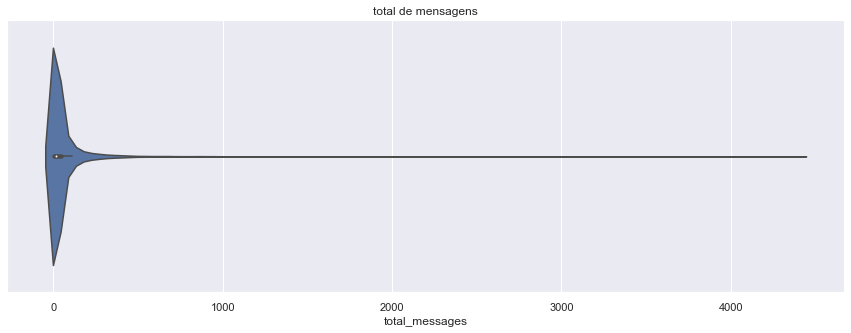

In [12]:
# active users
values = df_users['total_messages']
plt.figure(figsize=(15,5))
plt.title('total de mensagens')
ax = sns.violinplot(x=values,color ='C0')
print(values.describe())
print('outliers',outlier(values))

# Defining malicious users using the distributions of variables
We consider only the active users for that

In [13]:
# only active users
# this definition is very important! We have to choose carefully!!!

df_active_users = df_users[df_users['total_messages'] >= 50]

count    1254.000000
mean        0.007161
std         0.012614
min         0.000000
25%         0.000000
50%         0.000000
75%         0.010959
max         0.108434
Name: misinformation_ratio, dtype: float64
outliers 0.02739787386526517


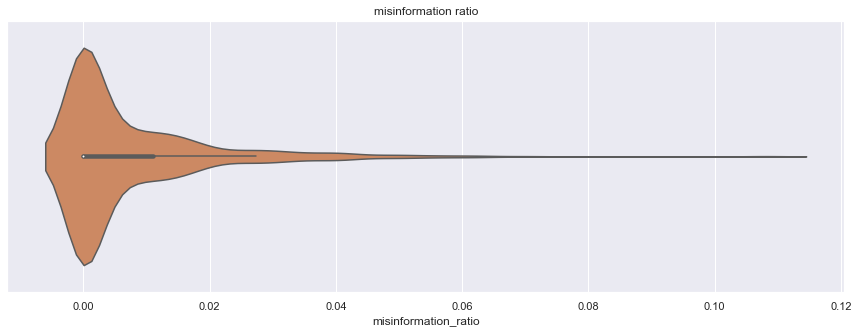

In [14]:
# source

values = df_active_users['misinformation_ratio']
plt.figure(figsize=(15,5))
plt.title('misinformation ratio')
ax = sns.violinplot(x=values,color ='C1')
print(values.describe())
print('outliers',outlier(values))


misinformation_ratio_threshold = outlier(values)


count    1254.000000
mean        1.398724
std         3.668707
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        49.000000
Name: misinformations, dtype: float64
outliers 2.5


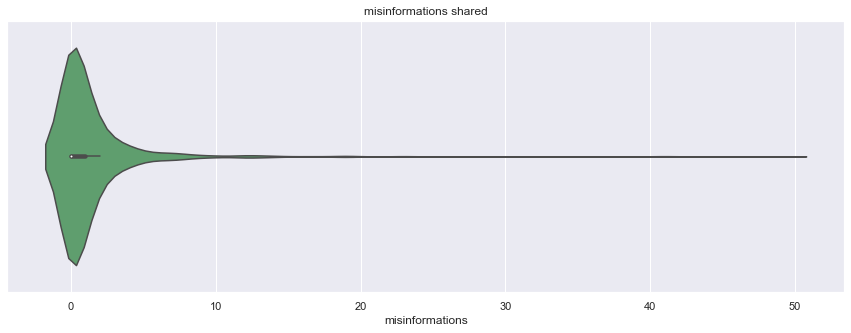

In [15]:
# absolute value

values = df_active_users['misinformations']
plt.figure(figsize=(15,5))
plt.title('misinformations shared')
ax = sns.violinplot(x=values, color = 'C2')
print(values.describe())
print('outliers',outlier(values))

misinformations_threshold = outlier(values)

count     1254.000000
mean       248.086124
std        696.258109
min          0.000000
25%          0.000000
50%          0.000000
75%        272.250000
max      11398.000000
Name: misinformation_for_reached_user, dtype: float64
outliers 680.625


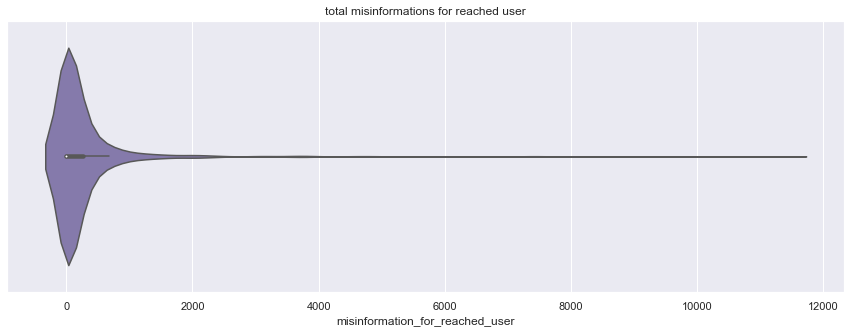

In [16]:
# relative to users value

values = df_active_users['misinformation_for_reached_user']
plt.figure(figsize=(15,5))
plt.title('total misinformations for reached user')
ax = sns.violinplot(x=values, color = 'C4')
print(values.describe())
print('outliers',outlier(values))

misinformation_for_reached_user_threshold = outlier(values)

In [24]:
# applying definitions
df_users['source_of_misinformation'] = [1 if x >= misinformation_ratio_threshold else 0 for x in df_users['misinformation_ratio']]
df_users['superspreader'] = [1 if x >= misinformation_for_reached_user_threshold else 0 for x in df_users['misinformation_for_reached_user']]
df_users['spreader'] = [1 if x >= misinformations_threshold else 0 for x in df_users['misinformations']]

df_users['malicious']  = ((df_users['source_of_misinformation'])  | (df_users['superspreader']) | (df_users['spreader']))
df_users.head()

,id,total_messages,viral_messages,texts,midia,urls,number_of_groups,reached_users,messages_for_reached_user,misinformations,...,users_misinformed,misinformation_for_reached_user,messages,preprocessed_messages,preprocessed_stemmed_messages,preprocessed_lemmatized_messages,source_of_misinformation,superspreader,spreader,malicious
0,-3818310068976662355,4396,22,3742,654,139,1,153,672588,0,...,0,0,Ontem eu vi um vídeo de um travesti xingando a...,ontem vi video travesti xingando ser blasfemou...,ont vi vide travest xing ser blasfem jesu comi...,ontem vir virdeo travestir xingar ser blasfema...,0,0,0,0
1,5782050016593913959,2332,223,972,1360,224,11,1710,498161,19,...,302,5738,Fazer campanha contraria tbm ajuda É verdade i...,fazer campanha contraria tbm ajuda verdade ? v...,faz campanh contr tbm ajud verdad ? vao entrev...,fazer campanha contrariar tbm ajudar verdade ?...,0,1,1,1
2,-2072140886659020977,2064,227,948,1116,295,3,534,391490,23,...,228,3436,Kkkk as urnas que são fraudadas kkkk essa desc...,kkk urnas sao fraudadas kkk desculpe ha ja deu...,kkk urn sao fraud kkk desculp ha ja deu ne ? ?...,kkk urna sao fraudar kkk desculpar ha ja dar n...,0,1,1,1
3,2839535797075678550,2020,104,1587,433,154,5,895,644390,8,...,759,2317,"*Ordem em meio a caos, o sucesso das escolas m...","* ordem meio caos , sucesso escolas militares ...","* ord mei cao , sucess escol milit . * \n \n _...","* ordem mear caos , sucesso escola militar . *...",0,1,1,1
4,170916900626840870,1810,96,828,982,253,1,153,276930,10,...,153,1530,Para bom entendedor meia palavra basta.\nNo ge...,"bom entendedor meia palavra basta . \n geral ,...","bom entend mei palavr bast . \n geral , ignor ...","bom entendedor meio palavra basto . \n geral ,...",0,1,1,1


In [25]:
#df_users.to_csv('data/2018/user_features.csv',index = False)

# Hypothesis
Most of misinformation is spread by malicious / untrustful users

In [26]:
malicious = set(df_users[df_users['malicious']==1]['id'])

# misinformation
total_mis = len(df[df['misinformation']==1])
print('total misinformation: ',total_mis)

def messages_by_superspreaders(user,superspreaders):
    if user in superspreaders:
        return True
    else:
        return False

superspreader_mask = []
for u in df['id']:
    superspreader_mask.append(messages_by_superspreaders(u,malicious))
    
df_superspreaders = df[superspreader_mask]
df_superspreaders = df_superspreaders[df_superspreaders['misinformation']==1]

print('total malicious users',len(df_superspreaders))
print('proportion of malicious users {a:.2f}'.format(a = len(malicious)/len(df_users)))
print('proportion of misinformation sent by malicious users: {a:.2f}'.format(a = len(df_superspreaders)/total_mis))

total misinformation:  2122
total malicious users 1660
proportion of malicious users 0.08
proportion of misinformation sent by malicious users: 0.78


In [27]:
sofn = set(df_users[df_users['source_of_misinformation']==1]['id'])
spreader = set(df_users[df_users['spreader']==1]['id'])
superspreader = set(df_users[df_users['superspreader']==1]['id'])

print('sources of misinformation', len(sofn))
print('spreader', len(spreader))
print('superspreader', len(superspreader))
print()
print('intersection sofn & spreader', len(sofn.intersection(spreader)))
print('intersection sofn & superspreader', len(sofn.intersection(superspreader)))
print('intersection superspreader & spreader', len(superspreader.intersection(spreader)))

print('intersection sofn & superspreader & spreader', len(superspreader.intersection(sofn.intersection(spreader))))


sources of misinformation 329
spreader 205
superspreader 113

intersection sofn & spreader 96
intersection sofn & superspreader 48
intersection superspreader & spreader 113
intersection sofn & superspreader & spreader 48


# Experiment design


### Models
* Classic machine learning
    * Logistic regression with SGD
    * Random forest
    * MLP or SVM
* Deep Learning
    * Char-level CNN

### Features
* User features: 'total_messages', 'viral_messages', 'texts', 'midia', 'urls', 'number_of_groups', 'reached_users', 'messages_for_reached_user'
* Text features: 
    * TF-IDF (2,2), 
    * Topics (LDA), 
    * Word2Vec
* Graph features?
    * Node2Vec

### Metrics
* Accuracy, precision, recall, F1, AUC

## Scenarios
* A: ML models with user features
* B: ML models with user features + text
* C: DL with chars
* D: DL + user features

# User representation

In [28]:
df_active_users.columns

Index(['id', 'total_messages', 'viral_messages', 'texts', 'midia', 'urls',
       'number_of_groups', 'reached_users', 'messages_for_reached_user',
       'misinformations', 'misinformation_ratio', 'users_misinformed',
       'misinformation_for_reached_user', 'messages', 'preprocessed_messages',
       'preprocessed_stemmed_messages', 'preprocessed_lemmatized_messages'],
      dtype='object')

In [30]:
# user data
df_active_users = df_users[df_users['total_messages'] >= 50]
user_features = ['total_messages', 'viral_messages', 'texts', 'midia', 'urls',
                 'number_of_groups', 'reached_users', 'messages_for_reached_user']
X_user = df_active_users[user_features]
y = df_active_users['malicious']

### Feature selection

In [31]:
X_user

,total_messages,viral_messages,texts,midia,urls,number_of_groups,reached_users,messages_for_reached_user
0,4396,22,3742,654,139,1,153,672588
1,2332,223,972,1360,224,11,1710,498161
2,2064,227,948,1116,295,3,534,391490
3,2020,104,1587,433,154,5,895,644390
4,1810,96,828,982,253,1,153,276930
...,...,...,...,...,...,...,...,...
1249,50,3,7,43,0,1,302,15100
1250,50,1,14,36,2,1,91,4550
1251,50,10,42,8,0,1,97,4850
1252,50,4,22,28,0,1,306,15300


In [32]:
# univariate
X_user.std()

total_messages                 240.898976
viral_messages                  28.701805
texts                          165.154320
midia                          110.731214
urls                            37.690269
number_of_groups                 1.079172
reached_users                  188.837356
messages_for_reached_user    51730.928558
dtype: float64

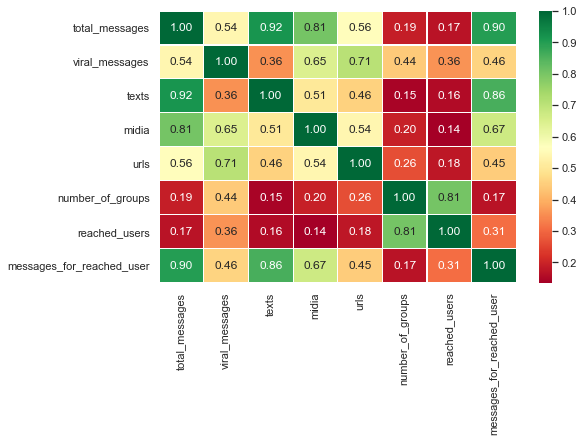

In [33]:
#get correlations of each features in dataset
corrmat = X_user.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(8,5))
#plot heat map
# sns.heatmap(df_similar, annot=True, fmt='.2f', linewidths=.1)
g=sns.heatmap(X_user[top_corr_features].corr(),annot=True, fmt='.2f', linewidths=.1,cmap="RdYlGn")

In [34]:
# feature importance

import pandas as pd
import numpy as np
data = pd.read_csv("D://Blogs//train.csv")
X = data.iloc[:,0:20]  #independent columns
y = data.iloc[:,-1]    #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

FileNotFoundError: [Errno 2] File D://Blogs//train.csv does not exist: 'D://Blogs//train.csv'

# Train-Test split

In [ ]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

# Feature engineering
* Representation
* Feature selection
* Dimensionality reduction
* Normalization

# Data balancing

# Hyperparameter tuning

# Test evaluation